In [1]:
using DataFrames, Gadfly
using Vec, LinearAlgebra
using GridWorldPathFollowing
using GraphUtils

┌ Info: Loading DataFrames support into Gadfly.jl
└ @ Gadfly /home/kylebrown/.julia/packages/Gadfly/09PWZ/src/mapping.jl:228


In [39]:
function plot_traj_with_steps(traj,grid_path;Δt=0.01,pad=0.01)
    t_range = get_start_time(traj):Δt:get_end_time(traj)
    plot(
        layer( x=[get_position(traj,t).x for t in t_range], y=[get_position(traj,t).y for t in t_range],
            Geom.path, Theme(default_color="black") ),
        layer( x=[get_start_pt(seg).x for seg in traj.segments], y=[get_start_pt(seg).y for seg in traj.segments],
            size=[8pt], Geom.point, Theme(default_color="red") ),
        layer( x=[get_end_pt(seg).x for seg in traj.segments], y=[get_end_pt(seg).y for seg in traj.segments],
            size=[8pt],Geom.point, Theme(default_color="yellow") ),
        layer( xmin=map(w->w.pt.x - grid_path.cellwidth/2, grid_path.waypoints) .+ pad,
            xmax=map(w->w.pt.x + grid_path.cellwidth/2, grid_path.waypoints) .- pad,
            ymin=map(w->w.pt.y - grid_path.cellwidth/2, grid_path.waypoints) .+ pad,
            ymax=map(w->w.pt.y + grid_path.cellwidth/2, grid_path.waypoints) .- pad,
            Geom.rect ),
        Coord.cartesian(fixed=true)
    )
end
function plot_vel_and_yaw_rate(traj;Δt=0.1)
    t_vec = collect(get_start_time(traj):Δt:get_end_time(traj))
    df = DataFrame(
        t=t_vec, 
        theta=[atan(get_heading(traj,t)) for t in t_vec],
        s=[get_dist(traj,t) for t in t_vec], 
        v=[norm(get_vel(traj,t)) for t in t_vec] )
    vstack( plot(df,x="t", y="theta",Geom.path), 
        plot(df,x="t",y="v",Geom.path,Theme(default_color="red")) )
end
function plot_accel_vel_pos(traj,t_vec)
    t = [[get_start_time(seg) for seg in traj.segments]..., get_end_time(traj)]
    cum_d = [0, cumsum([get_length(seg) for seg in traj.segments])...]
    vstack(
        plot(
            layer(x=t_vec[1:end-1],y=accel,Geom.step,Theme(default_color="green")),
            layer(x=t_vec,y=vel,Geom.path,Theme(default_color="red")),
            Guide.manual_color_key("",["accel","vel"],["green","red"])
        ),
        plot(
            layer(x=t_vec,y=pos,Geom.path,Theme(default_color="blue")),
            layer(x = t,y = cum_d,Geom.step,Theme(default_color="black")),
            Guide.manual_color_key("",["pos"],["blue"])
        )
    )
end

plot_accel_vel_pos (generic function with 1 method)

In [3]:
start_pt = VecE2(0.0,0.0)
start_time = 0.0
action_sequence = [DOWN,RIGHT,WAIT,UP,RIGHT,WAIT,WAIT,RIGHT,RIGHT,DOWN,DOWN,LEFT,UP,LEFT,DOWN,LEFT,LEFT]
# action_sequence = [RIGHT,WAIT,UP,RIGHT]
cell_width = 1.0
transition_time = 2.0
grid_path = construct_grid_world_path(start_pt,start_time,action_sequence,cell_width,transition_time)

traj = construct_trajectory(grid_path)
verify(traj)
t_vec, accel, vel, pos = optimize_velocity_profile(traj;a_max=1.25);
dense_traj = DenseTrajectory(traj,t_vec,accel,vel,pos);

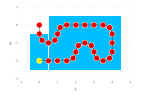

In [4]:
p = plot_traj_with_steps(traj,grid_path)
draw(SVG("traj_with_steps.svg"), p)
p

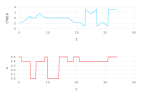

In [5]:
p = plot_vel_and_yaw_rate(traj)
draw(SVG("vel_and_yaw_rate.svg"), p)
p

# Optimize Velocity Profile
We apply a polynomial acceleration command in each time window

In [6]:
t_vec, accel, vel, pos = optimize_velocity_profile(traj;a_max=1.25);

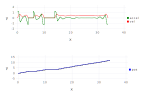

In [7]:
p = plot_accel_vel_pos(traj,t_vec)
draw(SVG("accel_vel_pos.svg"), p)
p

# Closed-loop tracking of Trajectory with optimized speed profile

In [8]:
dense_traj = DenseTrajectory(traj,t_vec,accel,vel,pos);

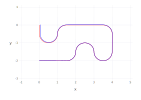

In [9]:
sim_model = UnicycleModel()
controller = TrackingController(k0=2.0,k1=2.0)
t0 = 0.0
tf = get_end_time(dense_traj)
dt = 0.05
state_pt = get_trajectory_point_by_time(dense_traj, t0)
initial_state = [state_pt.pos.x, state_pt.pos.y, atan(state_pt.heading)] + .1*rand(3)
states, cmds = simulate(sim_model,controller,dense_traj,initial_state,t0,tf,dt)

time_vec = collect(t0:dt:tf)
errors = Vector{Float64}()
for (t,state) in zip(time_vec,states)
    target_pt = get_trajectory_point_by_time(dense_traj, t)
    target = [target_pt.pos.x, target_pt.pos.y, atan(target_pt.heading)]
    push!(errors, norm(target[1:2] - state[1:2]))
end

p = plot(
    layer( x=[s[1] for s in states], y=[s[2] for s in states], Geom.path,Theme(default_color="blue")),
    layer( x=[get_position(dense_traj,t).x for t in time_vec], y=[get_position(dense_traj,t).y for t in time_vec],
        Geom.path,Theme(default_color="red") ),
    Coord.Cartesian(fixed=true)
)
draw(SVG("tracking.svg"), p)
p

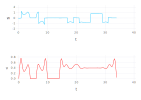

In [10]:
df = DataFrame(t=time_vec[1:end-1],v=[u[2] for u in cmds],w=[u[1] for u in cmds])
p = vstack(
    plot(df,x="t",y="w",Geom.path),
    plot(df,x="t",y="v",Geom.path,Theme(default_color="red"))
)
draw(SVG("control_command_profile.svg"), p)
p

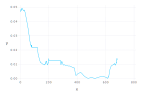

In [11]:
p = plot( x=collect(1:length(errors)), y=errors, Geom.path )
draw(SVG("tracking_error.svg"), p)
p

# Optimize controller params

In [12]:
function optimize_controller_params(sim_model,traj,initial_state;
        dt=0.1,
        k0_range=1.0:0.25:4.0,
        k1_range=1.0:0.25:4.0
    )
    t0 = get_start_time(traj)
    tf = get_end_time(traj)

    opt_vec = [NaN,NaN]
    opt_cost = Inf
    for k0 in k0_range
        for k1 in k1_range
            controller = TrackingController(k0=k0,k1=k1)
            states, cmds = simulate(sim_model,controller,traj,initial_state,t0,tf,dt)
            err = 0.0
            for (t,state) in zip(collect(t0:dt:tf),states)
                target_pt = get_trajectory_point_by_time(traj, t)
                target = [target_pt.pos.x, target_pt.pos.y, atan(target_pt.heading)]
                err += norm(target[1:2] - state[1:2])^2
            end
            if err < opt_cost
                opt_vec = [k0,k1]
            end
        end
    end
    opt_vec
end

optimize_controller_params (generic function with 1 method)

In [13]:
state_pt = get_trajectory_point_by_time(dense_traj, t0)
initial_state = [state_pt.pos.x, state_pt.pos.y, atan(state_pt.heading)] - 0.01*rand(3)
optimize_controller_params(sim_model,dense_traj,initial_state)

2-element Array{Float64,1}:
 4.0
 4.0

# Tracking stationary spinning paths--does it work?

In [14]:
c = VecE2(0.0,0.0)
r = 0.0
θ1 = 0.0
w = 1.0
dt = 1.0
T = 4
traj = Trajectory([ConstSpeedArcTrajectory(c,r,θ1+w*(t-1)*dt,w*dt,TimeInterval(dt*(t-1),dt*t)) for t in 1:T])
verify(traj)

# t_vec = collect(0.0:0.01:T)
# accel = zeros(length(t_vec)-1)
# vel = zeros(length(t_vec))
# pos = zeros(length(t_vec))
# dense_traj = DenseTrajectory(traj,t_vec,accel,vel,pos)
# verify(dense_traj)

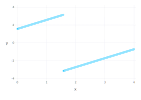

In [15]:
plot(x=collect(0:0.01:T),y=[atan(get_heading(traj,t)) for t in collect(0:0.01:T)])

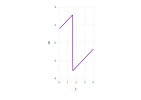

In [16]:
sim_model = UnicycleModel()
controller = TrackingController(k0=2.0,k1=2.0)
t0 = 0.0
tf = get_end_time(traj)
dt = 0.05
state_pt = get_trajectory_point_by_time(traj, t0)
initial_state = [state_pt.pos.x, state_pt.pos.y, atan(state_pt.heading)] + 0.001*rand(3)
states, cmds = simulate(sim_model,controller,traj,initial_state,t0,tf,dt)

time_vec = collect(t0:dt:tf)
errors = Vector{Float64}()
for (t,state) in zip(time_vec,states)
    target_pt = get_trajectory_point_by_time(traj, t)
    target = [target_pt.pos.x, target_pt.pos.y, atan(target_pt.heading)]
    push!(errors, norm(target[1:2] - state[1:2]))
end

df = DataFrame(
    t=time_vec,
    θ=[wrap_to_pi(s[3]) for s in states[1:length(time_vec)]],
    θ_des=[atan(get_heading(traj,t)) for t in time_vec]
)

p = plot(
    layer(df, x="t", y="θ", Geom.path,Theme(default_color="blue")),
    layer(df, x="t", y="θ_des",Geom.path,Theme(default_color="red") ),
    Coord.Cartesian(fixed=true),Guide.manual_color_key("",["θ","θ_des"],["blue","red"])
)

# Track a Multi-Stage Composite Path with a turn-in-place in the middle

In [46]:
cell_width = 1.0
transition_time = 2.0
grid_path1 = construct_grid_world_path(VecE2(0.0,0.0),0.0,
    [DOWN,RIGHT,WAIT,UP,WAIT],cell_width,transition_time)
traj1 = construct_trajectory(grid_path1)
Δt = 2.0 # time between end of traj1 and start of traj2
grid_path2 = construct_grid_world_path(get_end_pt(traj1),get_end_time(traj1)+Δt,
    [WAIT,RIGHT,DOWN,RIGHT,WAIT,UP],cell_width,transition_time)
traj2 = construct_trajectory(grid_path2)
traj_join = Trajectory()
θ1 = atan(get_heading(traj1,get_end_time(traj1)))
θ2 = atan(get_heading(traj2,get_start_time(traj2)))
Δθ = get_angular_offset(θ1,θ2)

push!(traj_join.segments, ConstSpeedArcTrajectory(get_end_pt(traj1),0.0,θ1-(π/2)*sign(Δθ),Δθ,
        TimeInterval(get_end_time(traj1),get_start_time(traj2))))

traj = Trajectory()
for seg in traj1.segments
    push!(traj.segments, seg)
end
for seg in traj_join.segments
    push!(traj.segments, seg)
end
for seg in traj2.segments
    push!(traj.segments, seg)
end
verify(traj)

t_vec, accel, vel, pos = optimize_velocity_profile(traj;a_max=1.25);
dense_traj = DenseTrajectory(traj,t_vec,accel,vel,pos);

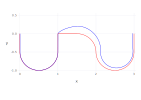

In [48]:
sim_model = UnicycleModel()
controller = TrackingController(k0=2.0,k1=2.0)
t0 = 0.0
tf = get_end_time(dense_traj)
dt = 0.05
state_pt = get_trajectory_point_by_time(dense_traj, t0)
initial_state = [state_pt.pos.x, state_pt.pos.y, atan(state_pt.heading)] + 0.01*rand(3)
states, cmds = simulate(sim_model,controller,dense_traj,initial_state,t0,tf,dt)

time_vec = collect(t0:dt:tf)
errors = Vector{Float64}()
for (t,state) in zip(time_vec,states)
    target_pt = get_trajectory_point_by_time(dense_traj, t)
    target = [target_pt.pos.x, target_pt.pos.y, atan(target_pt.heading)]
    push!(errors, norm(target[1:2] - state[1:2]))
end

p = plot(
    layer( x=[s[1] for s in states], y=[s[2] for s in states], Geom.path,Theme(default_color="blue")),
    layer( x=[get_position(dense_traj,t).x for t in time_vec], y=[get_position(dense_traj,t).y for t in time_vec],
        Geom.path,Theme(default_color="red") ),
    Coord.Cartesian(fixed=true)
)

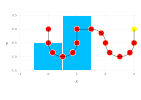

In [49]:
plot_traj_with_steps(traj,grid_path1)

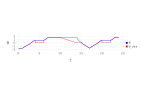

In [50]:
df = DataFrame(
    t=time_vec,
    θ=[wrap_to_pi(s[3]) for s in states[1:length(time_vec)]],
    θ_des=[atan(get_heading(traj,t)) for t in time_vec]
)

p = plot(
    layer(df, x="t", y="θ", Geom.path,Theme(default_color="blue")),
    layer(df, x="t", y="θ_des",Geom.path,Theme(default_color="red")),
    Coord.Cartesian(fixed=true),Guide.manual_color_key("",["θ","θ_des"],["blue","red"])
)

In [51]:
traj1.segments

7-element Array{AbstractTrajectory,1}:
 ConstSpeedStraightTrajectory(VecE2(0.000, 0.000), VecE2(0.000, -1.000), 0.5, TimeInterval(0.0, 1.0))                                 
 ConstSpeedArcTrajectory(VecE2(0.500, -0.500), 0.5, 3.141592653589793, 0.7853981633974483, 3.9269908169872414, TimeInterval(1.0, 2.0))
 ConstSpeedArcTrajectory(VecE2(0.500, -0.500), 0.5, 3.9269908169872414, 0.7853981633974483, 4.71238898038469, TimeInterval(2.0, 3.0)) 
 ConstSpeedArcTrajectory(VecE2(0.500, -0.500), 0.5, 4.71238898038469, 0.7853981633974483, 5.497787143782138, TimeInterval(3.0, 4.0))  
 ConstSpeedArcTrajectory(VecE2(0.500, -0.500), 0.5, 5.497787143782138, 0.0, 5.497787143782138, TimeInterval(4.0, 6.0))                
 ConstSpeedArcTrajectory(VecE2(0.500, -0.500), 0.5, 5.497787143782138, 0.7853981633974483, 6.283185307179586, TimeInterval(6.0, 7.0)) 
 ConstSpeedStraightTrajectory(VecE2(1.000, -0.500), VecE2(0.000, 1.000), 0.5000000000000001, TimeInterval(7.0, 10.0))                 

In [62]:
seg = traj1.segments[5]
get_heading(seg,get_start_time(seg))

2-element VecE2{Float64}:
 0.7071067811865477
 0.7071067811865474